# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Camera Calibration
To correct distortion, we will calibrate the camera.  The following calibration follows the [OpenCV Camera Calibration tutorial](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html).
### Variable Initialization

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

nx, ny = (9, 6)

chessboard_imgs = glob.glob('./camera_cal/calibration*.jpg')

# arrays to store object points and image points from all images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image place

# prepare object points, like (0, 0, 0), ... (7, 5, 0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x, y coords

### Calculate camera matrix and distortion coefficients

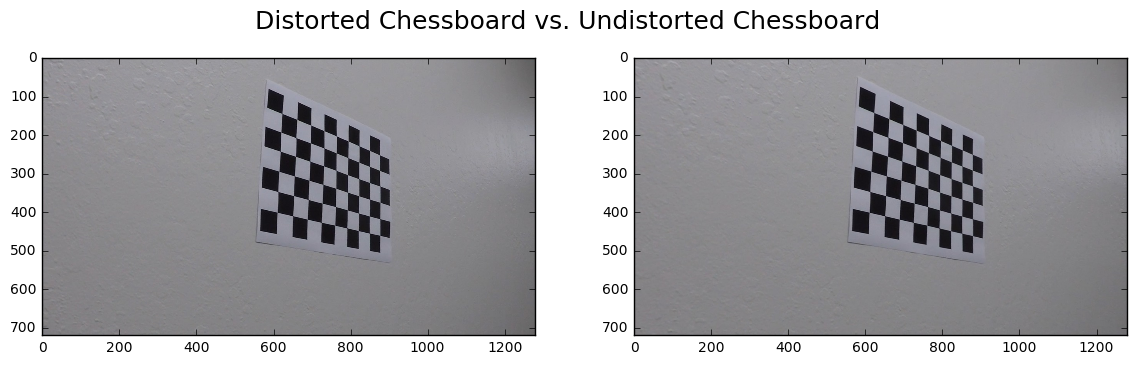

In [2]:
for fname in chessboard_imgs:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # if corners found, add object points, image points
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)  

# Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Sample image
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

fig, axarr = plt.subplots(1, 2)
fig.set_size_inches((14,4))
fig.suptitle('Distorted Chessboard vs. Undistorted Chessboard', fontsize=18)
axarr[0].imshow(img)
axarr[1].imshow(undistorted_img)
plt.show()

### Distortion Correction

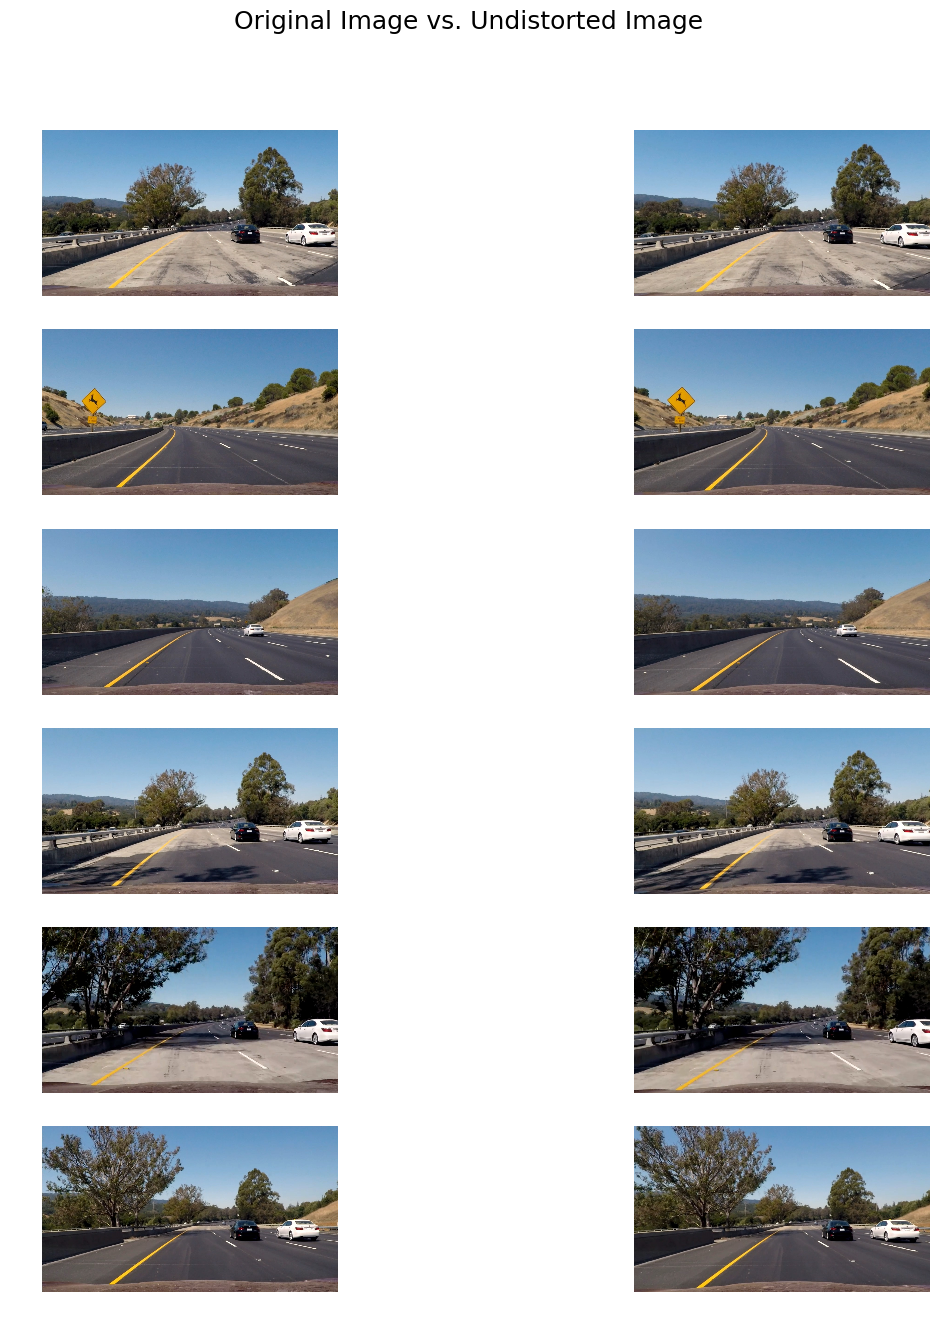

In [3]:
test_image_file_names = glob.glob('./test_images/test*.jpg')
fig, axarr = plt.subplots(len(test_image_file_names), 2) # two columns
fig.set_size_inches((14,15))
fig.suptitle('Original Image vs. Undistorted Image', fontsize=18)

calibrated_images = []
for idx, fname in enumerate(test_image_file_names):
    img = mpimg.imread(fname)

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    calibrated_images.append(dst)

    axarr[idx, 0].imshow(img)
    axarr[idx, 1].imshow(dst) # show undistorted img in 2nd column
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')
plt.show()

## Create Binary Thresholded Images
By detecting yellow, red and white pixels (within specific ranges), a binary image is created.  This binary image is a strong representation of the lane lines (though with other noise included).

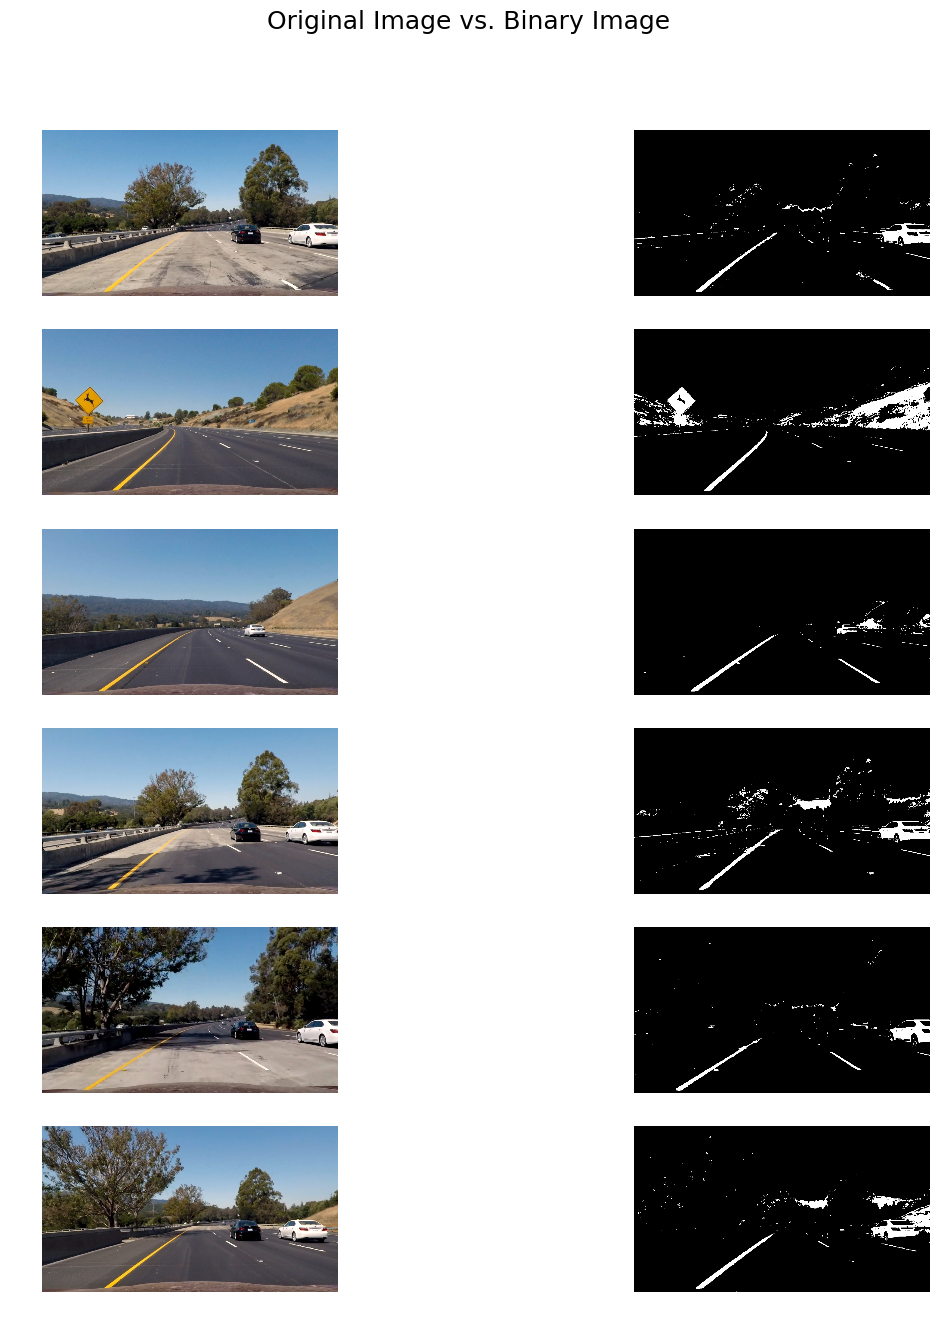

In [4]:
fig, axarr = plt.subplots(len(calibrated_images), 2) # two columns
fig.set_size_inches((14,15))
fig.suptitle('Original Image vs. Binary Image', fontsize=18)

def extract_white_and_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    yellow = cv2.inRange(hsv, (10, 100, 100), (70, 255, 255))
    red = cv2.inRange(img, (220, 0, 0), (255, 255, 255))
    white_1 = cv2.inRange(hsv, (0, 0, 185), (255, 20, 255))
    white_2 = cv2.inRange(hsl, (0, 195, 0), (255, 255, 60))
    white_3 = cv2.inRange(img, (200, 200, 200), (255, 255, 255))

    return yellow | red | white_1 | white_2 | white_3

binary_images = []
for idx, img in enumerate(calibrated_images):
    binary_img = extract_white_and_yellow(img)

    binary_images.append(binary_img)

    axarr[idx, 0].imshow(img)
    axarr[idx, 1].imshow(binary_img, cmap='gray') # show binary img in 2nd column
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')

## Perspective Transform
A perspective transform is applied to the region above to obtain a "bird's eye view" to the lanes.  For a better idea of how perspective transform works, I will show a perspective transform done on the undistorted images.  Then, I will do a perspective transform on the masked binary images.

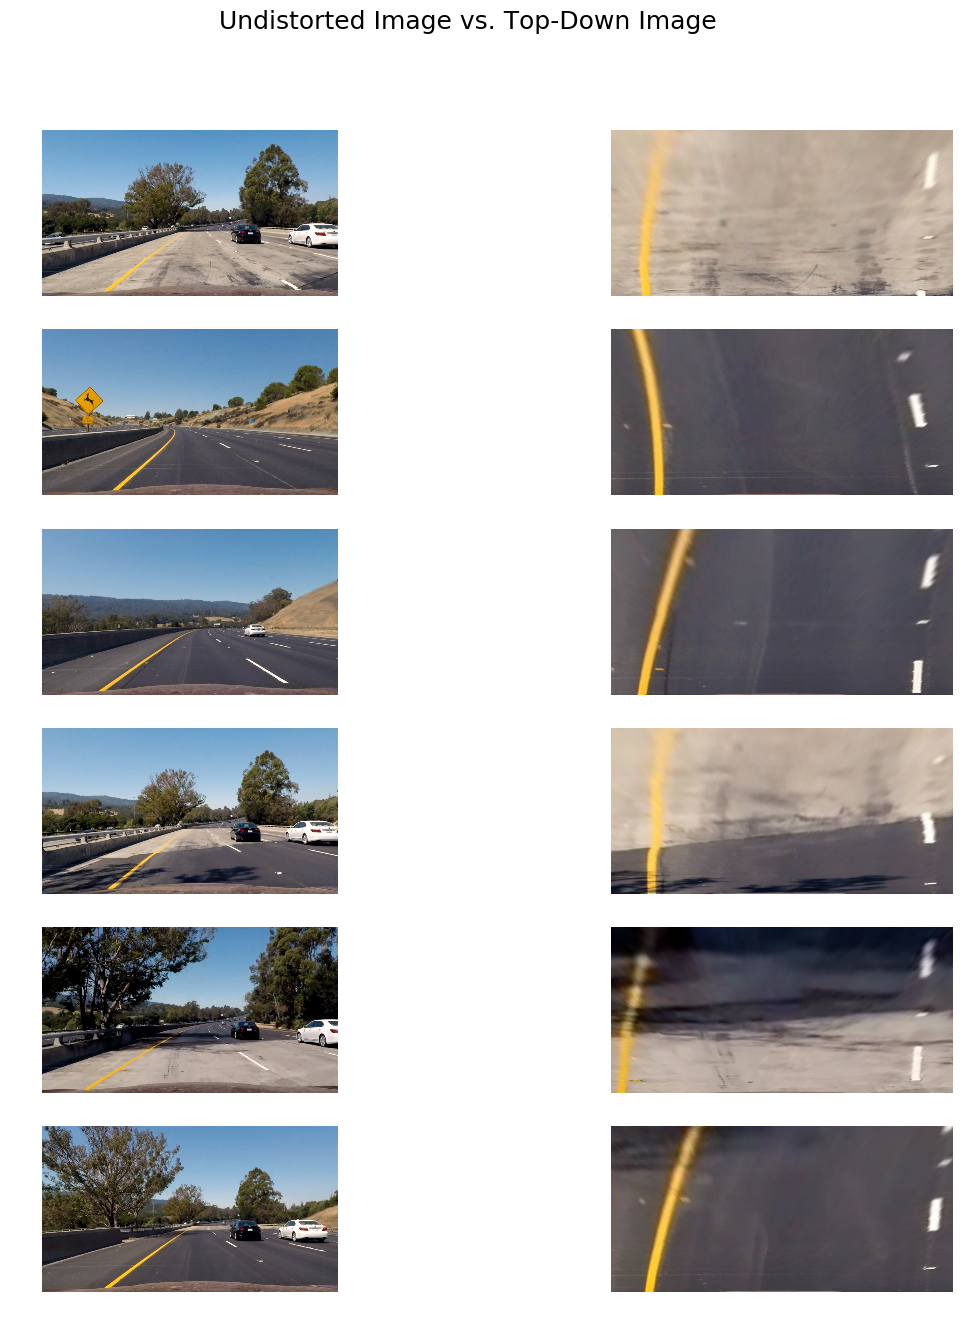

In [5]:
def perspective_warp(img):
    x_size = img.shape[1]
    y_size = img.shape[0]
    bottom_offset = 40

    src_bottom_left = np.array([200, y_size-bottom_offset])
    src_top_left = np.array([550, 470])
    src_top_right = np.array([750, 470])
    src_bottom_right = np.array([1180, y_size-bottom_offset])
    src_points = np.float32([src_bottom_left, src_top_left, src_top_right, src_bottom_right])

    # calculate the height and width of the warped image
    dst_width_bottom = np.sqrt(((src_bottom_right[0] - src_bottom_left[0])**2) + ((src_bottom_right[1] - src_bottom_left[1])**2))
    dst_width_top = np.sqrt(((src_top_right[0] - src_top_left[0])**2) + ((src_top_right[1] - src_top_left[1])**2))
    dst_width = int(max(dst_width_bottom, dst_width_top))

    dst_height_left = np.sqrt(((src_top_left[0] - src_bottom_left[0])**2) + ((src_top_left[1] - src_bottom_left[1])**2))
    dst_height_right = np.sqrt(((src_top_right[0] - src_bottom_right[0])**2) + ((src_top_right[1] - src_bottom_right[1])**2))
    dst_height = int(max(dst_height_left, dst_height_right))

    dst_bottom_left = np.array([0, dst_height-1])
    dst_top_left = np.array([0, 0])
    dst_top_right = np.array([dst_width-1, 0])
    dst_bottom_right = np.array([dst_width-1, dst_height-1])
    dst_points = np.float32([dst_bottom_left, dst_top_left, dst_top_right, dst_bottom_right])

    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    warped = cv2.warpPerspective(img, M, (dst_width, dst_height), flags=cv2.INTER_LINEAR)

    return Minv, warped

# warp and show perspective transform on undistorted images
fig, axarr = plt.subplots(len(calibrated_images), 2) # two columns
fig.set_size_inches((14,15))
fig.suptitle('Undistorted Image vs. Top-Down Image', fontsize=18)

for idx, calibrated_img in enumerate(calibrated_images):
    Minv, warped = perspective_warp(calibrated_img)
    
    axarr[idx, 0].imshow(calibrated_img)
    axarr[idx, 1].imshow(warped)
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')
plt.show()

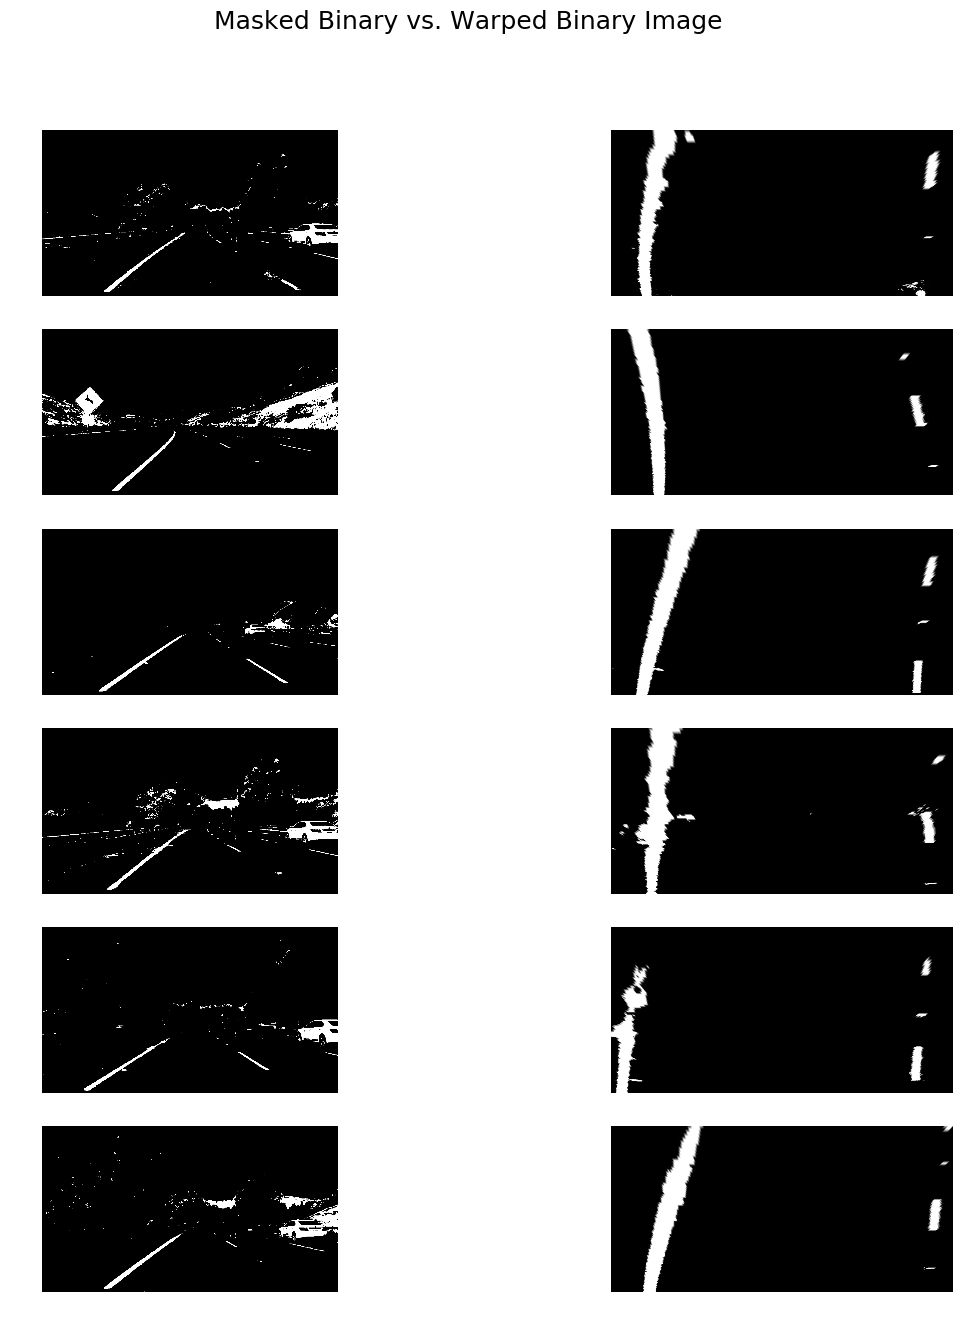

In [6]:
fig, axarr = plt.subplots(len(binary_images), 2) # two columns
fig.set_size_inches((14,15))
fig.suptitle('Masked Binary vs. Warped Binary Image', fontsize=18)

warped_images = []
for idx, binary_image in enumerate(binary_images):
    _, warped = perspective_warp(binary_image)
    warped_images.append(warped)
    
    axarr[idx, 0].imshow(binary_image, cmap='gray')
    axarr[idx, 1].imshow(warped, cmap='gray')
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')
plt.show()

## Finding Lane Lines
### Calculate Pixel Counts for Left and Right Halves
To find lane lines, the base of the left and right lines must first be found.  To find the bases, a histogram of the pixel counts by image column is derived where the peaks represent the base of the lane lines.

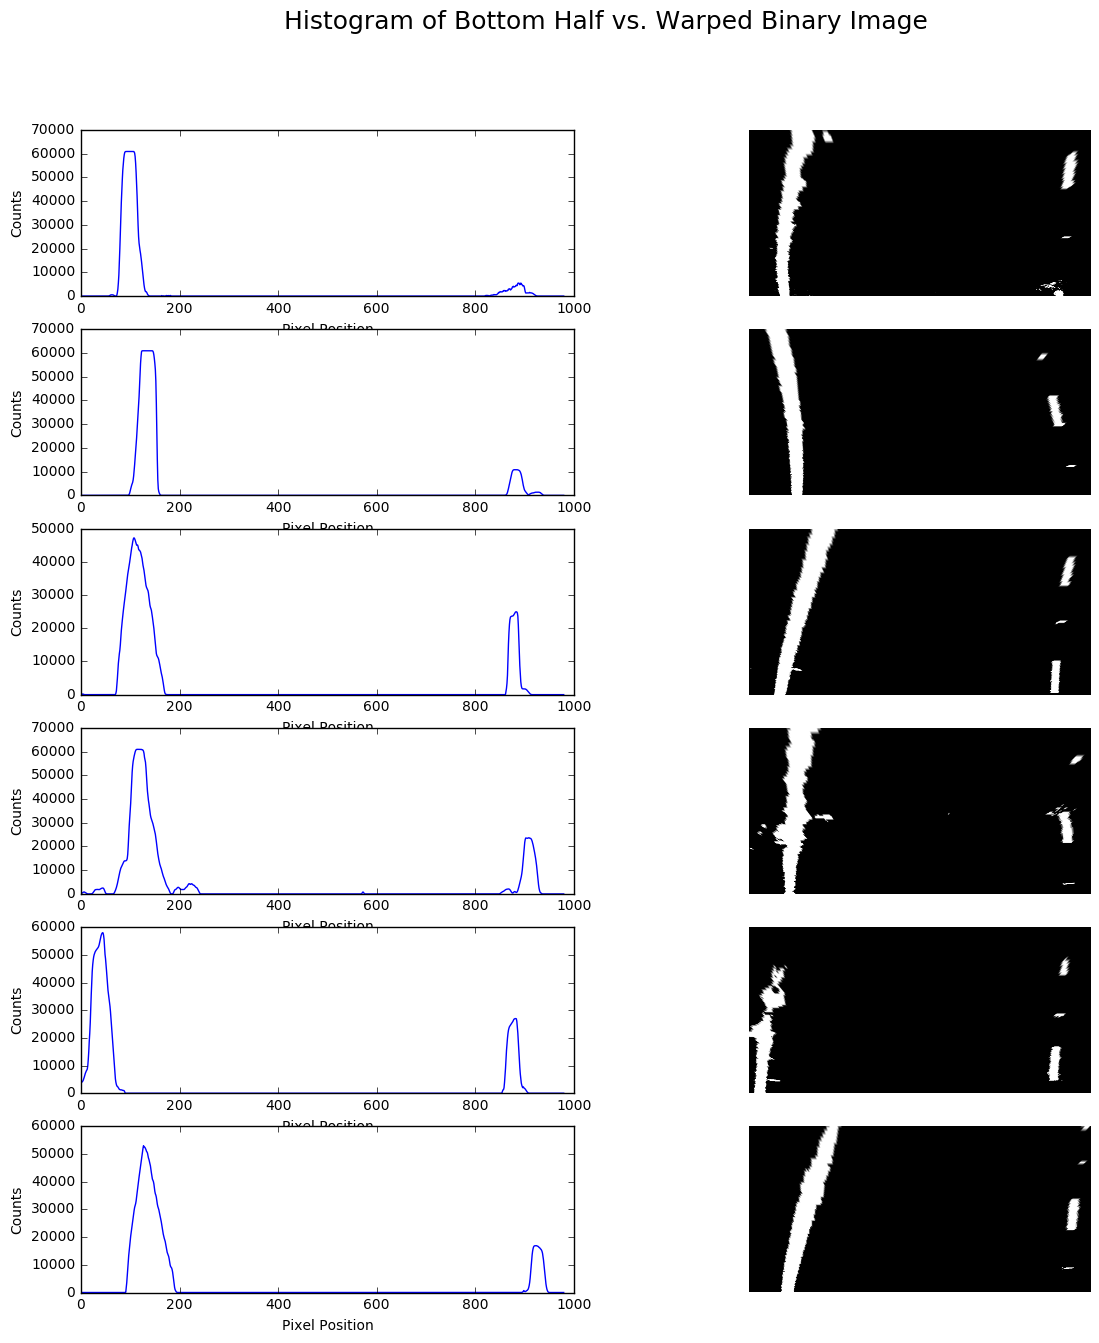

In [7]:
def find_basepoints(img):
    histogram = np.sum(img[int(img.shape[0]//2):, :], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lanes
    midpoint = np.int(histogram.shape[0]/2)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    return (left_x_base, right_x_base), histogram

fig, axarr = plt.subplots(len(warped_images), 2) # two columns
fig.set_size_inches((14,15))
fig.suptitle('Histogram of Bottom Half vs. Warped Binary Image', fontsize=18)

warped_img_basepoints = []
for idx, warped_img in enumerate(warped_images):
    basepoints, histogram = find_basepoints(warped_img)
    warped_img_basepoints.append(basepoints)

    axarr[idx, 0].plot(histogram)
    axarr[idx, 0].set_xlabel('Pixel Position')
    axarr[idx, 0].set_ylabel('Counts')
    axarr[idx, 1].imshow(warped_img, cmap='gray')
    axarr[idx, 1].axis('off')
plt.show()

### Sliding Windows Technique to Detect Lines and Curvature / Camera Offset Calculations
The [sliding windows technique](http://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/) is used to find the lane lines.  The windows will be stacked vertically and center around the pixel position with the highest pixel count.  Curvature will also be calculated.

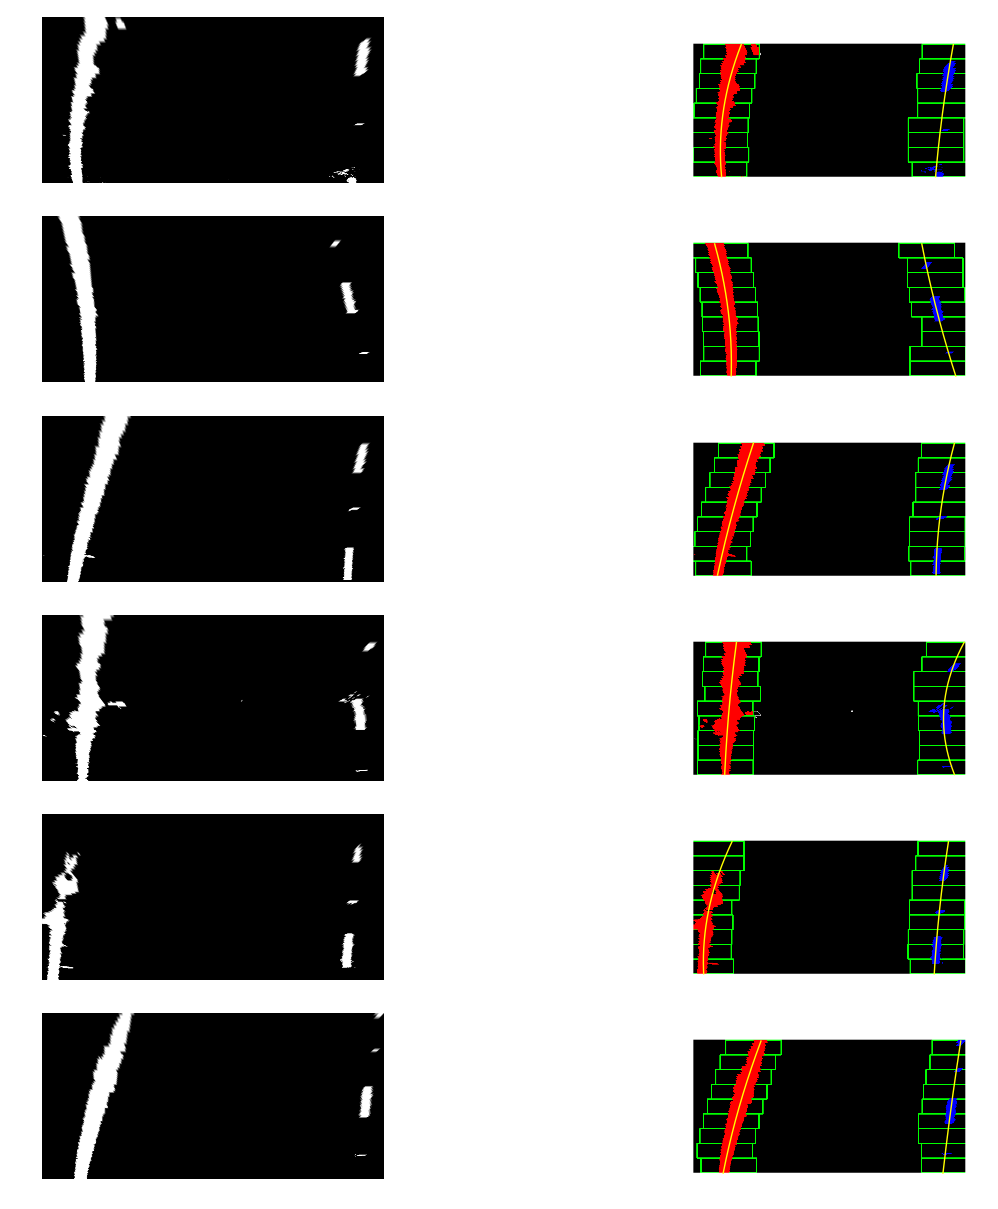

In [8]:
def calculate_curvature(A, B, y):
    return ((1 + (2*A*y + B)**2)**1.5) / np.absolute(2*A)


def window_search_best_fit_lanes(img, img_basepoints, draw_windows=False, draw_img=None):
    num_windows = 9
    window_height = np.int(img.shape[0]/num_windows)
    nonzero_pixel_locs = img.nonzero()
    nonzero_y = np.array(nonzero_pixel_locs[0])
    nonzero_x = np.array(nonzero_pixel_locs[1])

    # lists that will receive the left and right lane pixel indices of each image
    left_lane_inds = []
    right_lane_inds = []

    # Current x and y positions are computed base positions
    left_x_current = img_basepoints[0]
    right_x_current = img_basepoints[1]

    window_margin = 100
    # window will recenter if number of pixels found above this number
    minpix = 50

    for window in range(num_windows):
        # identify window boundaries for x and y of both lanes
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_left_x_low = left_x_current - window_margin
        win_left_x_high = left_x_current + window_margin
        win_right_x_low = right_x_current - window_margin
        win_right_x_high = right_x_current + window_margin

        if draw_windows and draw_img is not None:
            # draw windows on the visualization image
            cv2.rectangle(draw_img, (win_left_x_low, win_y_low), (win_left_x_high, win_y_high), (0, 255, 0), 3)
            cv2.rectangle(draw_img, (win_right_x_low, win_y_low), (win_right_x_high, win_y_high), (0, 255, 0), 3)

        # nonzero pixels in x and y within window
        valid_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_left_x_low) & (nonzero_x < win_left_x_high)).nonzero()[0]
        valid_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_right_x_low) & (nonzero_x < win_right_x_high)).nonzero()[0]

        left_lane_inds.append(valid_left_inds)
        right_lane_inds.append(valid_right_inds)

        if len(valid_left_inds) > minpix:
            left_x_current = np.int(np.mean(nonzero_x[valid_left_inds]))
        if len(valid_right_inds) > minpix:
            right_x_current = np.int(np.mean(nonzero_x[valid_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # extract left and right lane pixel positions
    left_x = nonzero_x[left_lane_inds]
    left_y = nonzero_y[left_lane_inds]
    right_x = nonzero_x[right_lane_inds]
    right_y = nonzero_y[right_lane_inds]
    
    # fit a second order polynomial
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)

    return left_fit, right_fit, left_x, right_x, left_y, right_y, left_lane_inds, right_lane_inds


def calculate_img_curvature(left_y, right_y, left_x, right_x, height):
    # Define conversions in x and y from pixels space to meters
    y_m_per_pix = 30/height # meters per pixel in y dimension
    x_m_per_pix = 3.7/650 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_y*y_m_per_pix, left_x*x_m_per_pix, 2)
    right_fit_cr = np.polyfit(right_y*y_m_per_pix, right_x*x_m_per_pix, 2)

    y_eval = np.max(plot_y) * y_m_per_pix
    left_lane_curvature = calculate_curvature(left_fit_cr[0], left_fit_cr[1], y_eval)
    right_lane_curvature = calculate_curvature(right_fit_cr[0], right_fit_cr[1], y_eval)
    curvature = np.average((left_lane_curvature, right_lane_curvature))
    return curvature


def calculate_camera_offset(left_fit_x, right_fit_x, img_shape):
    x_m_per_pix = 3.7/650 # meters per pixel in x dimension
    camera_position = img_shape[1]/2
    lane_center = (left_fit_x[img_shape[0]-1] + right_fit_x[img_shape[0]-1])/2
    center_offset_pixels = abs(camera_position - lane_center)
    return center_offset_pixels * x_m_per_pix


fig, axarr = plt.subplots(len(warped_images), 2) # two columns
fig.set_size_inches((14,15))

camera_offsets = []
curvatures = []
best_fits = []
plot_ys = []
out_imgs = []
for idx, warped_img in enumerate(warped_images):
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    nonzero = warped_img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    window_info = window_search_best_fit_lanes(warped_img, warped_img_basepoints[idx], True, out_img)
    left_fit, right_fit, left_x, right_x, left_y, right_y, left_lane_inds, right_lane_inds = window_info

    # Visualization
    plot_y = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
    left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
    right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
    plot_ys.append(plot_y)
    best_fits.append((left_fit_x, right_fit_x))

    # Curvature
    curvature = calculate_img_curvature(left_y, right_y, left_x, right_x, warped_img.shape[0])
    curvatures.append(curvature)

    # camera offset
    rw_center_offset_pixels = calculate_camera_offset(left_fit_x, right_fit_x, warped_img.shape)
    camera_offsets.append(rw_center_offset_pixels)

    # left lane red, right lane blue
    out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]
    
    out_imgs.append(out_img)
    axarr[idx, 0].imshow(warped_img, cmap='gray')
    axarr[idx, 0].axis('off')
    axarr[idx, 1].imshow(out_img)
    axarr[idx, 1].plot(left_fit_x, plot_y, color='yellow')
    axarr[idx, 1].plot(right_fit_x, plot_y, color='yellow')
    axarr[idx, 1].axis('off')
plt.show()

## Draw Lane Lines onto Original Image
The lane lines can be unwarped onto the original image.

**Note:** The curvature for the first picture is horribly off due to a left lane line that was detected as rather straight.

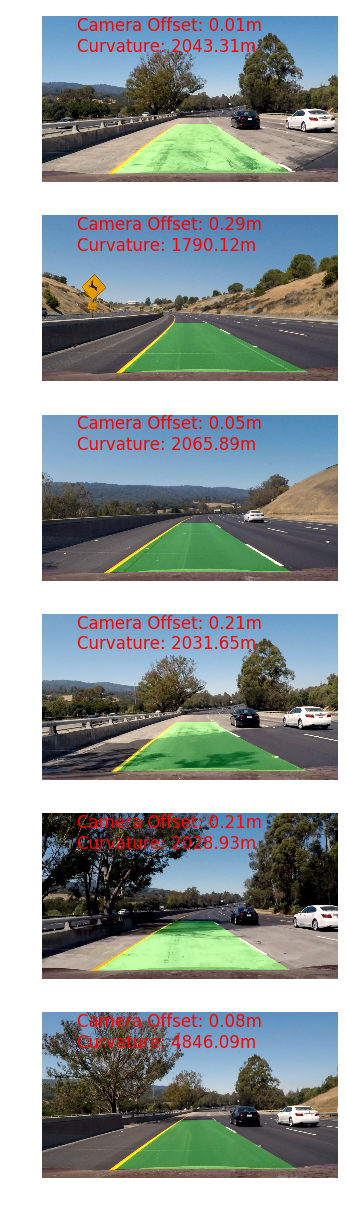

In [9]:
def warped_lane_lines_to_original(img, warped_img, best_fit, plot_y, Minv):
    left_fit_x = best_fit[0]
    right_fit_x = best_fit[1]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, plot_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # warp back to original image space
    unwarped = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)

    return result
    
fig, axarr = plt.subplots(len(warped_images))
fig.set_size_inches((14,15))

for idx, warped_img in enumerate(warped_images):
    img = mpimg.imread(test_image_file_names[idx])
    best_fit = best_fits[idx]
    plot_y = plot_ys[idx]

    result = warped_lane_lines_to_original(img, warped_img, best_fit, plot_y, Minv)

    axarr[idx].imshow(result)
    axarr[idx].text(150, 150, 'Camera Offset: {:2.2f}m\nCurvature: {:2.2f}m'.format(camera_offsets[idx], curvatures[idx]), color='red', size=12)
    axarr[idx].axis('off')
plt.show()

# Process Video
At this point, the pipeline for finding a lane line (and the curvature and camera offset) has been created.  The entire pipeline can used for videos as well (which is just a series of images).

The pipeline will:
  * calibrate each image
  * find the yellow and white pixels in the image
  * focus only on the region of the image in front of the camera
  * perspective warp the lane lines
  * use window search to find the best fit lines for each lane

In [10]:
def process_image(img):
    calibrated_img = cv2.undistort(img, mtx, dist, None, mtx)
    binary_img = extract_white_and_yellow(calibrated_img)

    Minv, warped_img = perspective_warp(binary_img)

    warped_img_basepoints, _ = find_basepoints(warped_img)

    window_info = window_search_best_fit_lanes(warped_img, warped_img_basepoints, True, out_img)
    left_fit, right_fit, left_x, right_x, left_y, right_y, left_lane_inds, right_lane_inds = window_info
    plot_y = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
    left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
    right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
    best_fit = (left_fit_x, right_fit_x)

    result = warped_lane_lines_to_original(img, warped_img, best_fit, plot_y, Minv)

    curvature = calculate_img_curvature(left_y, right_y, left_x, right_x, warped_img.shape[0])
    rw_center_offset_pixels = calculate_camera_offset(left_fit_x, right_fit_x, warped_img.shape)
    img_text = "Curvature: {:2.2f}m Camera Offset: {:2.2f}m".format(curvature, rw_center_offset_pixels)
    cv2.putText(result, img_text, (100, 100), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 3)

    return result

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
output_file_name = 'lane_lines.mp4'
clip1 = VideoFileClip('project_video.mp4')
lane_line_clip = clip1.fl_image(process_image)
%time lane_line_clip.write_videofile(output_file_name, audio=False)

[MoviePy] >>>> Building video lane_lines.mp4
[MoviePy] Writing video lane_lines.mp4


100%|█████████▉| 1260/1261 [02:51<00:00,  4.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lane_lines.mp4 

CPU times: user 4min 35s, sys: 17.6 s, total: 4min 53s
Wall time: 2min 54s
